In [31]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

In [32]:
class CoregionalizeKernel(nn.Module):
    def __init__(self, base_kernel, num_tasks, rank_R):
        super().__init__()
        self.base_kernel = base_kernel
        self.W = nn.Parameter(0.1 * torch.randn(num_tasks, rank_R))
        self.v = nn.Parameter(1e-2 * torch.ones(num_tasks))

    def forward(self, X1, task1, X2, task2):
        task1 = task1.to(torch.long)
        task2 = task2.to(torch.long)

        device = X1.device
        task1 = task1.to(device)
        task2 = task2.to(device)
        
        K_input = self.base_kernel(X1, X2)
        B = self.W @ self.W.T + torch.diag(self.v)
        B = B.to(device)
        
        B_tasks = B[task1, :][:, task2]
        return K_input * B_tasks

In [33]:
# class rbf_kernel(nn.Module):
#     def __init__(self, input_dim, lengthscale_init=1.0):
#         super().__init__()
#         self.log_lengthscale = nn.Parameter(torch.log(torch.tensor(lengthscale_init)))
    
#     def forward(self, X1, X2):
#         """
#         Compute RBF kernel matrix between X1 and X2
#         """
#         # Ensure X1 and X2 have compatible shapes for cdist
#         X1 = X1 / self.log_lengthscale.exp()
#         X2 = X2 / self.log_lengthscale.exp()
        
#         # Reshape if needed to ensure they are treated as 2D (N, D) arrays
#         if X1.ndimension() == 1:
#             X1 = X1.unsqueeze(0)
#         if X2.ndimension() == 1:
#             X2 = X2.unsqueeze(0)

#         # print(f"X1 shape: {X1.shape}, X2 shape: {X2.shape}")
        
#         sqdist = torch.cdist(X1, X2, p=2).pow(2)
#         return torch.exp(-0.5 * sqdist)

class rbf_kernel(nn.Module):
    def __init__(self, input_dim, lengthscale_init=1.0):
        super().__init__()
        self.input_dim = input_dim
        # Use one lengthscale per dimension (ARD - Automatic Relevance Determination)
        self.log_lengthscale = nn.Parameter(torch.log(torch.ones(input_dim) * lengthscale_init))

    def forward(self, X1, X2):
        """
        Compute RBF (Gaussian) kernel matrix between X1 and X2 using ARD lengthscales.
        Args:
            X1: Tensor of shape (N1, D)
            X2: Tensor of shape (N2, D)
        Returns:
            Kernel matrix of shape (N1, N2)
        """
        # Ensure input is 2D
        if X1.ndimension() == 1:
            X1 = X1.unsqueeze(0)
        if X2.ndimension() == 1:
            X2 = X2.unsqueeze(0)

        # Scale by lengthscale (ARD: each dimension can have a different scale)
        X1_scaled = X1 / self.log_lengthscale.exp()
        X2_scaled = X2 / self.log_lengthscale.exp()

        # Compute squared Euclidean distance
        sqdist = torch.cdist(X1_scaled, X2_scaled, p=2).pow(2)

        # Compute RBF
        return torch.exp(-0.5 * sqdist)


In [34]:
class MultiOutputSVGP(nn.Module):
    def __init__(self, input_dim, num_tasks, num_inducing):
        super().__init__()
        self.input_dim = input_dim
        self.num_tasks = num_tasks
        self.num_inducing = num_inducing

        # Shared inducing points Z
        self.Z = nn.Parameter(torch.randn(num_inducing, input_dim))

        # Variational parameters
        self.m = nn.Parameter(torch.zeros(num_inducing))  # Mean of variational distribution
        self.L = nn.Parameter(torch.eye(num_inducing))  # Lower-triangular Cholesky of S

        # Base kernel
        self.kernel = rbf_kernel(input_dim)

        # Coregionalization matrix B (T x T)
        self.B = nn.Parameter(torch.eye(num_tasks))

    def compute_coregionalized_kernel(self, X1, T1, X2, T2):
        """
        Coregionalized kernel: K((x,t), (x',t')) = k(x,x') * B[t,t']
        """
        k_base = self.kernel(X1, X2)  # [N, M]
        B_selected = self.B[T1][:, T2]  # [N, M]
        return k_base * B_selected
    
    def forward(self, X, T, Y, full_n):
        """
        X: [B, D], input features
        T: [B], task indices
        Y: [B], binary labels (0 or 1)
        full_n: total number of training samples (for scaling ELBO)
        """
        B = X.shape[0]  # batch size
        M = self.num_inducing

        # Compute kernel matrices
        Kxz = self.compute_coregionalized_kernel(X, T, self.Z, torch.zeros(M, dtype=torch.long))  # [B, M]
        Kzz = self.compute_coregionalized_kernel(self.Z, torch.zeros(M, dtype=torch.long),
                                                 self.Z, torch.zeros(M, dtype=torch.long)) + 1e-6 * torch.eye(M)

        # Compute predictive mean and variance of q(f)
        Lzz = torch.linalg.cholesky(Kzz)
        Kzz_inv = torch.cholesky_inverse(Lzz)

        S = self.L @ self.L.T  # Ensure positive-definite

        mean_f = Kxz @ Kzz_inv @ self.m  # [B]
        cov_f = (Kxz @ Kzz_inv @ S @ Kzz_inv @ Kxz.T).diag()  # [B]
        std_f = torch.sqrt(cov_f + 1e-6)

        # Monte Carlo sampling (approximation of latent function)
        eps = torch.randn_like(mean_f)
        f_sample = mean_f + std_f * eps

        # Sigmoid for binary classification
        prob = torch.sigmoid(f_sample)

        # Log likelihood term (binary cross-entropy for classification)
        log_lik = Y * F.logsigmoid(f_sample) + (1 - Y) * F.logsigmoid(-f_sample) # Log-likelihood of Bernoulli
        log_lik_term = (full_n / B) * log_lik.sum()

        # KL[q(u) || p(u)] (variational KL divergence)
        KL = 0.5 * (
            torch.trace(Kzz_inv @ S) +
            self.m @ Kzz_inv @ self.m -
            M +
            torch.logdet(Kzz) - torch.logdet(S + 1e-6 * torch.eye(M))
        )

        elbo = log_lik_term - KL
        return -elbo  # minimize negative ELBO

    def predict(self, X_test, T_test):
        """
        X_test: [B_test, D], test input features
        T_test: [B_test], task indices for the test set
        """
        self.eval()
        B_test = X_test.shape[0]  # batch size of test points
        M = self.num_inducing

        # Compute kernel between test points and inducing points
        Kxz_test = self.compute_coregionalized_kernel(X_test, T_test, self.Z, torch.zeros(M, dtype=torch.long))  # [B_test, M]

        # Compute kernel between inducing points
        Kzz = self.compute_coregionalized_kernel(self.Z, torch.zeros(M, dtype=torch.long),
                                                 self.Z, torch.zeros(M, dtype=torch.long)) + 1e-6 * torch.eye(M)

        # Cholesky decomposition of Kzz
        Lzz = torch.linalg.cholesky(Kzz)
        Kzz_inv = torch.cholesky_inverse(Lzz)

        # Compute the posterior mean: Kxz_test * Kzz_inv * m
        mean_f_test = Kxz_test @ Kzz_inv @ self.m  # [B_test]

        # Compute the posterior covariance: Kxz_test * Kzz_inv * S * Kzz_inv * Kxz_test.T
        S = self.L @ self.L.T  # Ensure positive-definite
        cov_f_test = (Kxz_test @ Kzz_inv @ S @ Kzz_inv @ Kxz_test.T).diag()  # [B_test]

        # Compute the posterior standard deviation
        std_f_test = torch.sqrt(cov_f_test + 1e-6)

        # Apply sigmoid to get probabilities
        prob_test = torch.sigmoid(mean_f_test)

        return prob_test, std_f_test

In [35]:
def dataset_generation(n_samples=100, n_tasks=3, input_dim=2, seed=None):
    """
    Generate a synthetic dataset for multi-output GP classification.

    Args:
        n_samples: Number of samples to generate.
        n_tasks: Number of tasks (outputs).
        input_dim: Dimensionality of input features.
        seed: Random seed for reproducibility.

    Returns:
        X: Input features (n_samples x input_dim).
        y: Binary labels (n_samples,).
        task_train: Task indices (n_samples,).
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    X = torch.randn(n_samples, input_dim)
    task_train = torch.randint(0, n_tasks, (n_samples,))

    # Default label generation logic
    y = torch.zeros(n_samples)

    for t in range(n_tasks):
        idx = (task_train == t)
        # Task-specific logic (you can change per use case)
        if input_dim == 1:
            y[idx] = (X[idx, 0] > 0).float()
        elif input_dim == 2:
            if t == 0:
                y[idx] = (X[idx, 0] > 0).float()
            elif t == 1:
                y[idx] = (X[idx, 1] > 0).float()
            else:
                y[idx] = (X[idx, 0] + X[idx, 1] > 0).float()
        else:
            # For input_dim > 2, define general rule
            feature_sum = X[idx, :min(input_dim, 5)].sum(dim=1)
            threshold = (t + 1) * 0.5  # vary threshold per task
            y[idx] = (feature_sum > threshold).float()

    return X, y, task_train

In [36]:
def train_svgp_classification(model, dataloader, optimizer, full_n, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        for X, T, Y in dataloader:
            optimizer.zero_grad()
            loss = model(X, T, Y, full_n)  # The forward pass calculates the negative ELBO
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Print loss and accuracy every 10 epochs
        if epoch % 10 == 9:
            total_loss /= len(dataloader)
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


In [37]:
num_tasks = 2
input_dim = 4
# 1. Generate Data
X, y, task_train = dataset_generation(n_samples=300, n_tasks=num_tasks, input_dim=input_dim, seed=42)

# Convert to torch tensors
X = X.clone().detach().float()
y = y.clone().detach().float()
task_train = task_train.clone().detach().long()

# 2. Train/Test Split
X_train, X_test, y_train, y_test, task_train_split, task_test_split = train_test_split(
    X, y, task_train, test_size=0.2, random_state=42, stratify=task_train
)

# Initialize the model and optimizer
svgp_model = MultiOutputSVGP(input_dim=input_dim, num_tasks=num_tasks, num_inducing=50)
optimizer = torch.optim.Adam(svgp_model.parameters(), lr=0.01)

# Prepare the DataLoader
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train, task_train_split, y_train)),
    batch_size=32,
    shuffle=True
)

# Train the model
train_svgp_classification(svgp_model, train_loader, optimizer, full_n=len(X_train), epochs=100)

Epoch 10, Loss: 147.6777
Epoch 20, Loss: 109.8058
Epoch 30, Loss: 100.3938
Epoch 40, Loss: 86.9021
Epoch 50, Loss: 83.4365
Epoch 60, Loss: 77.1301
Epoch 70, Loss: 75.6668
Epoch 80, Loss: 72.9892
Epoch 90, Loss: 73.3744
Epoch 100, Loss: 65.1845


In [38]:
def evaluate_svgp_classification(model, X_test, T_test, y_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for evaluation
        # Make predictions
        prob_test, _ = model.predict(X_test, T_test)  # Predict class probabilities
        
        # Apply threshold to get predicted labels (0 or 1)
        predicted = (prob_test >= 0.5).float()

        # Compute accuracy
        accuracy = (predicted.squeeze() == y_test).float().mean().item()
        print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate the model on the test set
evaluate_svgp_classification(svgp_model, X_test, task_test_split, y_test)

Test Accuracy: 0.9500


In [39]:
from sklearn.decomposition import PCA

def visualize_dataset(X, y, task_ids, input_dim=2, title="Multi-output GP Dataset"):
    """
    Visualize a multi-output classification dataset.

    Args:
        X (torch.Tensor): Feature matrix of shape [N, D].
        y (torch.Tensor): Binary labels [N].
        task_ids (torch.Tensor): Task indices [N].
        input_dim (int): Dimensionality of input features.
        title (str): Title for the figure.
    """
    X_np = X.detach().cpu().numpy()
    y_np = y.detach().cpu().numpy()
    task_np = task_ids.detach().cpu().numpy()
    
    if input_dim > 2:
        # Reduce to 2D using PCA
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X_np)
    else:
        X_vis = X_np

    unique_tasks = sorted(set(task_np))
    num_tasks = len(unique_tasks)

    fig, axes = plt.subplots(1, num_tasks, figsize=(5 * num_tasks, 4), squeeze=False)
    fig.suptitle(title, fontsize=16)

    for i, task in enumerate(unique_tasks):
        ax = axes[0, i]
        idx = task_np == task
        ax.scatter(
            X_vis[idx, 0],
            X_vis[idx, 1],
            c=y_np[idx],
            cmap="coolwarm",
            edgecolor='k',
            alpha=0.7
        )
        ax.set_title(f"Task {task}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


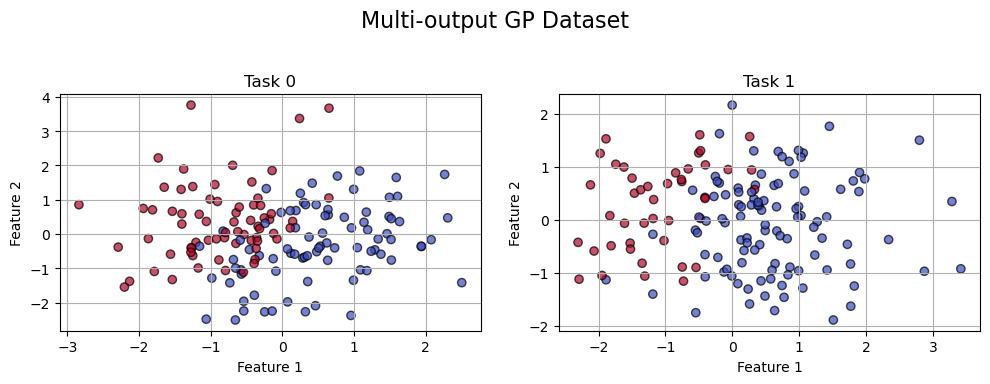

In [40]:
# Visualize
visualize_dataset(X, y, task_train, input_dim=X.shape[1])